<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize for-loop style code with Dask Delayed.  This approach is more flexible and more manual than automatic approaches like Dask Dataframe.  It is commonly useful to parallelize existing codebases, or to build tools like Dask Dataframe.

To see a real-world application you may with to read about [Credit Modeling with Dask](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for Dask in general.

In this notebook we start with toy examples to build understanding.  Then we end with two examples that build a dataframe and machine learning algorithm.

Objectives:

1.  Use Dask delayed to build custom task graphs
2.  Build an intuition for computational task scheduling generally
3.  Learn how tools like Dask Dataframe and Dask-ML work internally

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1 ms, sys: 1 ms, total: 2 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel because they are independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed* object is made, which keeps track of the function to call and the arguments to pass to it.


In [3]:
import dask

In [4]:
%%time

# This executes actual code sequentially

# x = inc(1)
# y = inc(2)
# z = add(x, y)

# This runs lazily, all it does is build a graph

x = dask.delayed(inc)(1)
y = dask.delayed(inc)(2)
z = dask.delayed(add)(x, y)

CPU times: user 0 ns, sys: 1 ms, total: 1 ms
Wall time: 691 µs


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [5]:
%%time

# This actually runs our computation using a local thread pool
z.compute()

CPU times: user 6 ms, sys: 3 ms, total: 9 ms
Wall time: 2.01 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [6]:
z

Delayed('add-c7f4ec9d-44ec-4b60-b450-9ebbce6c2280')

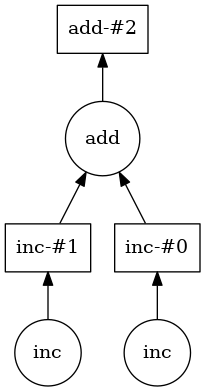

In [7]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [8]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [9]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 8 ms, sys: 2 ms, total: 10 ms
Wall time: 8.01 s


In [10]:
total

44

In [11]:
%%time
results = []
for x in data:
    y = dask.delayed(inc)(x)
    results.append(y)
    
total = dask.delayed(sum)(results)

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.47 ms


In [12]:
# %load solutions/01-delayed-loop.py
results = []

for x in data:
    y = dask.delayed(inc)(x)
    results.append(y)

total = dask.delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed


Before computing: Delayed('sum-034ba48a-9159-4669-9265-a759c3eae723')
After computing : 44


How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delay`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

## Start a Dask Cluster on Kubernetes

The code above ran in threads in your local Jupyter notebook.  Now we'll now start up a Dask cluster on Kubernetes.

*Note: if you still have a cluster running in your other notebook you may want to close that cluster, or restart your notebook.  Otherwise your dashboard will point to the previous cluster.*

    cluster.close()

In [13]:
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster(n_workers=20)
#cluster

import dask.multiprocessing
dask.config.set(scheduler='processes')

from dask.distributed import Client

#client = Client(cluster)
client = Client()

In [14]:
#from dask.distributed import Client
#client = Client(cluster)

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [15]:
def inc(x):
    sleep(1)
    return x + 1

def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 607 ms, sys: 61 ms, total: 668 ms
Wall time: 10 s


In [18]:
results = []
for x in data:
    if is_even(x):  # even
        y = dask.delayed(double)(x)
    else:          # odd
        y = dask.delayed(inc)(x)
    results.append(y)

total = dask.delayed(sum)(results)


In [19]:
%time total.compute()

CPU times: user 180 ms, sys: 24 ms, total: 204 ms
Wall time: 3.05 s


90

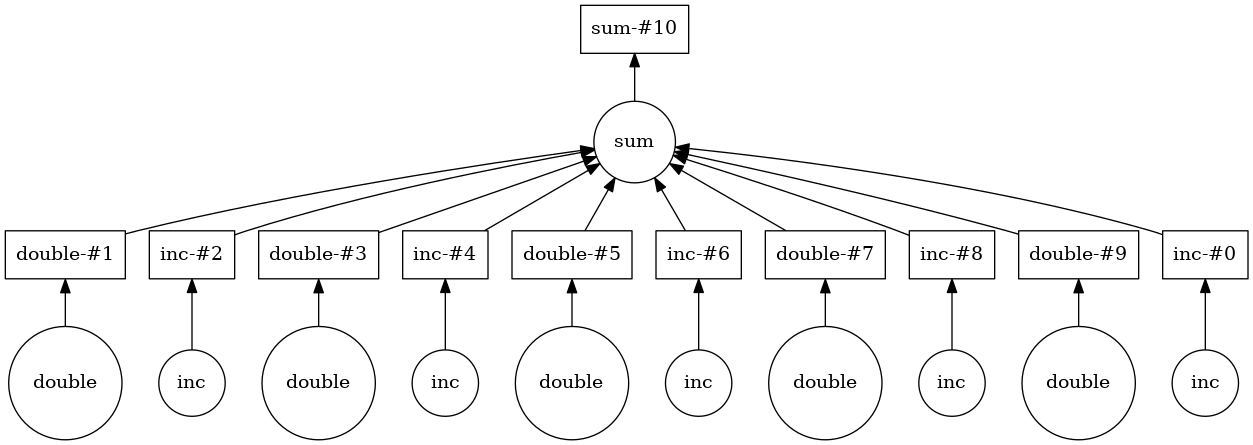

In [20]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Rebuild Dataframe algorithms manually

In the last notebook we used Dask Dataframe to load CSV data from the cloud and then perform some basic analyses.  In these examples Dask dataframe automatically built our parallel algorithms for us.

In this section we'll do that same work, but now we'll use Dask delayed to construct these algorithms manually.  In practice you don't have to do this because Dask dataframe already exists, but doing it once, manually can help you understand both how Dask dataframe works, and how to parallelize your own code.

To make things a bit faster we've also decided to store data in the Parquet format.  We'll use Dask delayed along with Arrow to read this data in many small parts, convert those parts to Pandas dataframes, and then do a groupby-aggregation.

### Inspect Parquet data on the cloud

Just like our CSV files, we also have many parquet files for the same data

In [21]:
import gcsfs
gcs = gcsfs.GCSFileSystem()
filenames = sorted(gcs.glob('anaconda-public-data/nyc-taxi/nyc.parquet/part.*.parquet'))
filenames[:5]

['anaconda-public-data/nyc-taxi/nyc.parquet/part.0.parquet',
 'anaconda-public-data/nyc-taxi/nyc.parquet/part.1.parquet',
 'anaconda-public-data/nyc-taxi/nyc.parquet/part.10.parquet',
 'anaconda-public-data/nyc-taxi/nyc.parquet/part.100.parquet',
 'anaconda-public-data/nyc-taxi/nyc.parquet/part.101.parquet']

We can read that data using the [gcsfs](https://gcsfs.readthedocs.io/en/latest/) library to access data on Google Cloud Storage, and either [PyArrow](https://arrow.apache.org/docs/python/) or [Fastparquet](https://fastparquet.readthedocs.io/en/latest/) to read those bytes.  

Here we'll use Arrow to turn one Parquet file into one Pandas dataframe.

In [22]:
import pyarrow.parquet as pq

fn = filenames[0]
with gcs.open(fn) as f:
    pf = pq.ParquetFile(f)  # Arrow ParquetFile
    table = pf.read()       # Arrow Table
    df = table.to_pandas()  # Pandas DataFrame

df

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2015-01-01 00:00:00,1,2015-01-01 00:11:26,5,4.00,-73.971436,40.760201,1,N,-73.921181,40.768269,2,13.5,0.5,0.5,0.00,0.0,0.0,14.50
1,2015-01-01 00:00:00,2,2015-01-01 00:00:00,1,1.68,-73.991547,40.750069,1,N,0.000000,0.000000,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80
2,2015-01-01 00:00:00,2,2015-01-01 00:00:00,3,1.56,-74.001320,40.729057,1,N,-74.010208,40.719662,1,7.5,0.5,0.5,0.00,0.0,0.3,8.80
3,2015-01-01 00:00:01,1,2015-01-01 00:03:49,1,0.80,-73.860847,40.757294,1,N,-73.868111,40.752285,2,5.0,0.5,0.5,0.00,0.0,0.0,6.30
4,2015-01-01 00:00:03,2,2015-01-01 00:21:48,2,2.57,-73.969017,40.754269,1,N,-73.994133,40.761600,2,14.5,0.5,0.5,0.00,0.0,0.3,15.80
5,2015-01-01 00:00:03,2,2015-01-01 00:10:50,1,1.58,-73.987579,40.765270,1,N,-73.976921,40.776970,1,9.0,0.5,0.5,1.90,0.0,0.3,12.20
6,2015-01-01 00:00:04,1,2015-01-01 00:10:44,3,2.50,-73.957008,40.774502,1,N,-73.966019,40.800617,2,10.5,0.5,0.5,0.00,0.0,0.0,11.80
7,2015-01-01 00:00:05,2,2015-01-01 00:10:52,2,1.30,-73.950500,40.769863,1,N,-73.950943,40.769825,1,8.5,0.5,0.5,2.00,0.0,0.3,11.80
8,2015-01-01 00:00:06,1,2015-01-01 00:00:48,2,0.00,-73.985367,40.710770,1,N,-73.984772,40.710682,3,2.5,0.5,0.5,0.00,0.0,0.0,3.80
9,2015-01-01 00:00:06,2,2015-01-01 00:15:15,3,5.62,-73.978104,40.786282,1,N,-74.010170,40.719971,2,18.0,0.5,0.5,0.00,0.0,0.3,19.30


### Build aggregation piece by piece

We want to compute the following operation on all of our data:

```python
import dask.dataframe as dd
df = dd.read_parquet('gcs://anaconda-public-data/nyc-taxi/nyc.parquet/part.*.parquet')
df.passenger_count.mean().compute()
```

This actually works, but lets pretend that it didn't, and lets build this up, chunk by chunk, file by file.

We do this for you sequentially below with a for loop:

In [29]:
%%time
sums = []
counts = []

def filename_to_dataframe(fn):
    gcs = gcsfs.GCSFileSystem()

    with gcs.open(fn) as f:
        pf = pq.ParquetFile(f)  # Arrow ParquetFile
        table = pf.read()       # Arrow Table
        df = table.to_pandas()  # Pandas DataFrame

    return df


for fn in filenames[:3]:

    # Read in parquet file to Pandas Dataframe
    df = filename_to_dataframe(fn)
    
    # Groupby origin airport
    total = df.passenger_count.sum()
    
    # Number of flights by origin
    count = df.passenger_count.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_sums = sum(sums)
total_counts = sum(counts)
mean = total_sums / total_counts
mean

CPU times: user 3.06 s, sys: 1.03 s, total: 4.09 s
Wall time: 7.37 s


### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = dask.delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```

So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [28]:
%%time

# copied sequential code
sums = []
counts = []

def filename_to_dataframe(fn):
    gcs = gcsfs.GCSFileSystem()

    with gcs.open(fn) as f:
        pf = pq.ParquetFile(f)  # Arrow ParquetFile
        table = pf.read()       # Arrow Table
        df = table.to_pandas()  # Pandas DataFrame

    return df


for fn in filenames[:3]:

    # Read in parquet file to Pandas Dataframe
    df = dask.delayed(filename_to_dataframe)(fn)
    
    # Groupby origin airport
    total = dask.delayed(sum)(df.passenger_count)
    
    # Number of flights by origin
    count = df.passenger_count.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_sums = dask.delayed(sum)(sums)
total_counts = dask.delayed(sum)(counts)
mean = total_sums / total_counts
mean

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.15 ms


If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [27]:
# %load solutions/01-delayed-dataframe.py
# copied sequential code
sums = []
counts = []

def filename_to_dataframe(fn):
    gcs = gcsfs.GCSFileSystem()

    with gcs.open(fn) as f:
        pf = pq.ParquetFile(f)  # Arrow ParquetFile
        table = pf.read()       # Arrow Table
        df = table.to_pandas()  # Pandas DataFrame

    return df


for fn in filenames:

    # Read in parquet file to Pandas Dataframe
    df = dask.delayed(filename_to_dataframe)(fn)

    # Groupby origin airport
    total = df.passenger_count.sum()

    # Number of flights by origin
    count = df.passenger_count.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_sums = dask.delayed(sum)(sums)
total_counts = dask.delayed(sum)(counts)
mean = total_sums / total_counts
mean
